In [1]:
import os
import string
import pickle
import re
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import sys
import random
from contextlib import redirect_stdout
from xml.dom.minidom import parse
from os import listdir
from tensorflow.keras import regularizers, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Dense, Dropout, Conv1D, MaxPool1D, Reshape, Concatenate, Flatten, Bidirectional, LSTM

# from nltk.parse.corenlp import CoreNLPDependencyParser, CoreNLPParser
# dep_parser = CoreNLPDependencyParser(url='http://localhost:9000/')
import spacy
nlp = spacy.load('en_core_web_sm')

!!! Se intentó también con BERT, pero al ser un modelo más pesado se tardó más tiempo en entrenar.

In [13]:
from transformers import BertTokenizer, TFBertForSequenceClassification

In [14]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Cargar roberta

In [2]:
from transformers import TFAutoModel
from transformers import AutoTokenizer

In [3]:
roberta = TFAutoModel.from_pretrained("distilroberta-base")

C:\ProgramData\Anaconda3\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Pablo\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [4]:
tokenizer = AutoTokenizer.from_pretrained("distilroberta-base")

In [5]:
# Configuración
datadir = "./data"
modelname = "ddi"

# Clase de configuración para los experimentos

Se añadió esta clase para realizar las configuraciones necesarias para cada experimento de una manera rápida, sencilla y legible:

In [6]:
class Configs:
    embbeding_dims = 100
    num_capas_conv = 1
    use_lstm = False
    use_lemmas = False
    use_roberta = False

    def __str__(self):
        print("Dimensiones para las capas embebidas: " + str(self.embbeding_dims))
        print("Número de capas convolucionales: " + str(self.num_capas_conv))
        print("LSTM: " + str(self.use_lstm))
        print("Lemas: " + str(self.use_lemmas))
        print("Utilizando Roberta: " + str(self.use_roberta))
        return "============="

# Clase que mappea las secuencias.

Solo se añadió la clase de configuraciones para habilitar el uso de lemas y roberta cuando sea necesario con base a los 6 experimentos realizados:

In [7]:
class Codemaps :
    def __init__(self, data, configs, maxlen=None) :

        self.configs = configs

        if isinstance(data,Dataset) and maxlen is not None :
            self.__create_indexs(data, maxlen)

        elif type(data) == str and maxlen is None :
            self.__load(data)

        else:
            print('codemaps: Invalid or missing parameters in constructor')
            exit()

    def __create_indexs(self, data, maxlen) :
        """
        Extrae todas las palabras y etiquetas de las oraciones dadas y crea los índices necesarios
        """
        self.maxlen = maxlen
        words = set([])
        lc_words = set([])
        lems = set([])
        pos = set([])
        labels = set([])

        for s in data.sentences() :
            for t in s['sent'] :
                words.add(t['form'])
                lc_words.add(t['lc_form'])
                lems.add(t['lemma'])
                pos.add(t['pos'])
            labels.add(s['type'])

        self.word_index = {w: i+2 for i,w in enumerate(sorted(list(words)))}
        self.word_index['PAD'] = 0 # Padding
        self.word_index['UNK'] = 1 # Unknown words

        self.lc_word_index = {w: i+2 for i,w in enumerate(sorted(list(lc_words)))}
        self.lc_word_index['PAD'] = 0 # Padding
        self.lc_word_index['UNK'] = 1 # Unknown words

        self.lemma_index = {s: i+2 for i,s in enumerate(sorted(list(lems)))}
        self.lemma_index['PAD'] = 0  # Padding
        self.lemma_index['UNK'] = 1  # Unseen lemmas

        self.pos_index = {s: i+2 for i,s in enumerate(sorted(list(pos)))}
        self.pos_index['PAD'] = 0  # Padding
        self.pos_index['UNK'] = 1  # Unseen PoS tags

        self.label_index = {t:i for i,t in enumerate(sorted(list(labels)))}

    def __load(self, name) :
        """
        Carga los índices
        """
        self.maxlen = 0
        self.word_index = {}
        self.lc_word_index = {}
        self.lemma_index = {}
        self.pos_index = {}
        self.label_index = {}

        with open(name+".idx") as f :
            for line in f.readlines():
                parts = line.split()
                if len(parts) == 3:
                    (t,k,i) = parts
                    if t == 'MAXLEN' : self.maxlen = int(k)
                    elif t == 'WORD': self.word_index[k] = int(i)
                    elif t == 'LCWORD': self.lc_word_index[k] = int(i)
                    elif t == 'LEMMA': self.lemma_index[k] = int(i)
                    elif t == 'POS': self.pos_index[k] = int(i)
                    elif t == 'LABEL': self.label_index[k] = int(i)


    def save(self, name) :
        """
        Guarda los índices
        """
        with open(name+".idx","w") as f :
            print ('MAXLEN', self.maxlen, "-", file=f)
            for key in self.label_index : print('LABEL', key, self.label_index[key], file=f)
            for key in self.word_index : print('WORD', key, self.word_index[key], file=f)
            for key in self.lc_word_index : print('LCWORD', key, self.lc_word_index[key], file=f)
            for key in self.lemma_index : print('LEMMA', key, self.lemma_index[key], file=f)
            for key in self.pos_index : print('POS', key, self.pos_index[key], file=f)

    def __code(self, index, k) :
        """
        Retorna el código para la clave k en el índice dado (O UNK)
        """
        return index[k] if k in index else index['UNK']

    def __encode_and_pad(self, data, index, key) :
        """
        Codifica las secuencias y añade padding
        """
        X = [[self.__code(index,w[key]) for w in s['sent']] for s in data.sentences()]
        X = pad_sequences(maxlen=self.maxlen, sequences=X, padding="post", value=index['PAD'])
        return X

    def encode_words(self, data) :
        """
        Codifica las palabras
        """
        # encode and pad sentence words
        Xw = self.__encode_and_pad(data, self.word_index, 'form')
        # encode and pad sentence lc_words
        Xlw = self.__encode_and_pad(data, self.lc_word_index, 'lc_form')
        # encode and pad lemmas
        Xl = self.__encode_and_pad(data, self.lemma_index, 'lemma')
        # encode and pad PoS
        Xp = self.__encode_and_pad(data, self.pos_index, 'pos')
        # modelo pre-entrenado de roberta
        X_pret = self.encode_words_pretrained(data)

        # return encoded sequences
        # return [Xw,Xlw,Xl,Xp] (or just the subset expected by the NN inputs)
        if self.configs.use_lemmas and self.configs.use_roberta: #dependiendo del experimento se retornan las diferentes entradas de datos
            return [Xw, Xl, X_pret]
        elif self.configs.use_lemmas:
            return [Xw, Xl]
        elif self.configs.use_roberta:
            return [Xw, X_pret]
        else:
            return Xw

    def encode_labels(self, data) :
        """
        Codifica las etiquetas
        """
        Y = [self.label_index[s['type']] for s in data.sentences()]
        Y = [to_categorical(i, num_classes=self.get_n_labels()) for i in Y]
        return np.array(Y)

    def encode_words_pretrained(self, data):
        sentences = [" ".join([w["form"] for w in s["sent"]]) for s in data.sentences()]
        X_pret = tokenizer(sentences, return_tensors="np", padding=True, truncation=True, max_length = self.maxlen)
        return X_pret["input_ids"]

    def get_n_words(self) :
        return len(self.word_index)

    def get_n_lc_words(self) :
        return len(self.lc_word_index)

    def get_n_labels(self) :
        return len(self.label_index)

    def get_n_lemmas(self) :
        return len(self.lemma_index)

    def get_n_pos(self) :
        return len(self.pos_index)

    def word2idx(self, w) :
        return self.word_index[w]

    def lcword2idx(self, w) :
        return self.lc_word_index[w]

    def label2idx(self, l) :
        return self.label_index[l]

    def idx2label(self, i) :
        for l in self.label_index :
            if self.label_index[l] == i:
                return l
        raise KeyError

# Clase para gestionar el análisis del árbol de dependencias

In [8]:
class Deptree :

    def __init__ (self, txt):
        if txt=="" :
            self.tree = None
        else :
            txt2 = txt.replace("/"," / ").replace("-"," - ").replace(".",". ").replace("'"," ' ")
            # self.tree, = dep_parser.raw_parse(txt2)
            self.tree = nlp(txt2)
            self.tree.user_data["offset_start"] = [-1, ] * len(self.tree)
            self.tree.user_data["offset_end"] = [-1, ] * len(self.tree)
            offset = 0
            tks = []
            for t, token in enumerate(self.tree):
                # enrich tree nodes with offset in original text.
                word = token.text
                offset = txt.find(word, offset)
                self.tree.user_data["offset_start"][t] = offset
                self.tree.user_data["offset_end"][t] = offset+len(word)-1
                offset += len(word)

    def get_n_nodes(self):
        """
        Return number of nodes in the tree (tokens in the sentece), (plus one for the fake root)
        """
        return len(self.tree)


    def get_ancestors(self,n) :
        """
        Retorna los ancestros de un nodo
        """
        anc = [n, ]
        while self.tree[n].head.i != self.tree[n].i:
            n = self.tree[n].head.i
            anc.append(n)
        return anc

    def get_parent(self,n):
        """
        Retorna el pradre de un nodo
        """
        if self.tree[n].head.i != self.tree[n].i:
            return None
        else :
            return self.tree[n].head.i

    def get_children(self,n) :
        """
        Retorna los hijos de un nodo
        """
        if self.tree is None:
            return []
        return [child.i for child in self.tree[n].children]

    def get_LCS(self,n1,n2) :
        """
        Retorna el LCS de dos nodos
        """
        # get ancestor list for each node
        a1 = self.get_ancestors(n1)
        a2 = self.get_ancestors(n2)
        # get first common element in both lists
        for i in range(len(a1)) :
            for j in range(len(a2)) :
                if a1[i] == a2[j] :
                    return a1[i]

        # (should never happen since tree root is always a common subsumer.)
        return None

    def get_fragment_head(self, start, end) :
        """
        Retorna el head de un segmento de la oración
        """
        # find which tokens overlap the fragment
        overlap = set()
        for t, token in enumerate(self.tree):
            tk_start, tk_end = self.get_offset_span(t)
            if tk_start <= start <= tk_end or tk_start <= end <= tk_end :
                overlap.add(t)

        head = None
        if len(overlap)>0 :
            # find head node among those overlapping the entity
            for t in overlap :
                if head is None: head = t
                else: head = self.get_LCS(head, t)

            # if found LCS does not overlap the entity, the parsing was wrong, forget it.
            if head not in overlap :
                head = None

        return head

    def get_word(self,n):
        """
        Retorna la palabra
        """
        return  self.tree[n].text if self.tree[n].text.strip() != "" else '<none>'

    def get_lemma(self,n):
        """
        Retorna el Lema
        """
        return  self.tree[n].lemma_ if self.tree[n].lemma_.strip() != "" else '<none>'

    def get_rel(self,n):
        """
        Retorna la relación sintáctica
        """
        return self.tree[n].dep_ if self.tree[n].dep_ is not None else '<none>'

    def get_tag(self,n):
        """
        Retorna el PoS tag
        """
        return self.tree[n].tag_ if self.tree[n].tag_ is not None else '<none>'

    def get_offset_span(self,n):
        """
        Retorna el offset
        """
        if n > len(self.tree) or n < 0:
            return -1,-1
        else:
            return self.tree.user_data["offset_start"][n], self.tree.user_data["offset_end"][n]

    def is_stopword(self,n):
        """
        Retorna True si la palabra es una stopword
        """
        return self.tree[n].tag_[0] not in ['N', 'V', 'J', 'R']

    def is_entity(self,n,entities):
        """
        Retorna True si la palabra corresponde a una entidad
        """
        for e in entities :
            if entities[e]["start"] <= self.tree.user_data["offset_start"][n] and self.tree.user_data["offset_end"][n] <= entities[e]["end"] :
                return e
        return None

    def get_subtree_offset_span(self,n):
        """
        Retorna el span cubierto por un sub-árbol en el nodo n
        """
        # if the node is a leaf, get its span
        left,right = self.get_offset_span(n)
        # if it is not a leaf, recurse into leftmost/rightmost children
        children = self.get_children(n)
        if children :
            l,r = self.get_subtree_offset_span(children[0])
            left = min(left,l)
            l,r = self.get_subtree_offset_span(children[-1])
            right = max(right,r)
        return left,right

    def get_up_path(self,n1,n2) :
        """
        Get upwards path from n1 to n2 (returns list of node ids, upwards, excluding n2)
        """
        path = self.get_ancestors(n1)
        if n2 not in path: # error, n2 is not ancestor of n1
            return None
        else:
            return path[:path.index(n2)]

    def get_down_path(self,n1,n2) :
        """
        Get downwards path from n1 to n2 (return list of node ids, downwards, excluding n1)
        """
        path = self.get_up_path(n2,n1)
        if path is not None: # if None, n1 was not ancestor of n2
            path.reverse()
        return path

    def print(self, n=0, d=0) :
        """
        Pinta el árbol de dependencias (para debug)
        """
        if n!=0 :
            print(d*'   ', end='')
            print(self.get_rel(n)+'('+self.get_lemma(n)+'_'+self.get_tag(n)+')')
        for c in self.get_children(n) :
            self.print(c, d+1)



# Clase de Dataset

In [9]:
class Dataset:
    def __init__(self, filename) :

        if filename[-4:] == ".pck" :
            # parameter is a pickle file, load it
            with open(filename, "rb") as pf:
                self.data = pickle.load(pf)

        else :
            # parameter must be a folder with XML data, load it
            self.data = []
            self.stext = []
            # process each file in directory
            for f in listdir(filename) :

                # parse XML file, obtaining a DOM tree
                tree = parse(filename+"/"+f)

                # process each sentence in the file
                sentences = tree.getElementsByTagName("sentence")
                for s in sentences :
                    sid = s.attributes["id"].value   # get sentence id
                    stext = s.attributes["text"].value   # get sentence text
                    ents = s.getElementsByTagName("entity")

                    # there are no entity pairs, skip sentence
                    if len(ents) <= 1 : continue

                    entities = {}
                    for e in ents :
                        # for discontinuous entities, we only get the first span
                        # (will not work, but there are few of them)
                        eid =  e.attributes["id"].value
                        typ =  e.attributes["type"].value
                        (start,end) = e.attributes["charOffset"].value.split(";")[0].split("-")
                        entities[eid] = {"start":int(start), "end":int(end), "type": typ}

                    # analyze sentence with stanford parser.
                    tree = Deptree(stext)

                    # for each pair in the sentence, get whether it is DDI and its type
                    pairs = s.getElementsByTagName("pair")
                    for p in pairs:
                        # ground truth
                        ddi = p.attributes["ddi"].value
                        if (ddi=="true") : dditype = p.attributes["type"].value
                        else : dditype = "null"
                        # target entities
                        e1 = p.attributes["e1"].value
                        e2 = p.attributes["e2"].value

                        sent = []
                        seen = set([])
                        for tk in range(1,tree.get_n_nodes()) :
                            tk_start, tk_end = tree.get_offset_span(tk)
                            tk_ent = tree.is_entity(tk, entities)

                            if tk_ent is None :
                                token = {'form': tree.get_word(tk), 'lc_form':tree.get_word(tk).lower(), 'lemma': tree.get_lemma(tk), 'pos': tree.get_tag(tk)}
                            elif tk_ent == e1 :
                                token = {'form':'<DRUG1>', 'lc_form':'<DRUG1>', 'lemma':'<DRUG1>', 'pos':'<DRUG1>', 'etype':entities[e1]['type']}
                            elif tk_ent == e2 :
                                token = {'form':'<DRUG2>', 'lc_form':'<DRUG1>', 'lemma':'<DRUG2>', 'pos':'<DRUG2>', 'etype':entities[e2]['type']}
                            else :
                                token = {'form':'<DRUG_OTHER>', 'lc_form':'<DRUG_OTHER>', 'lemma':'<DRUG_OTHER>', 'pos':'<DRUG_OTHER>', 'etype':entities[tk_ent]['type']}

                            if tk_ent is None or tk_ent not in seen:
                                sent.append(token)
                            if tk_ent is not None:
                                seen.add(tk_ent)

                        # resulting vector
                        self.data.append({'sid': sid, 'e1':e1, 'e2':e2, 'type':dditype, 'sent':sent})

    def save(self, filename) :
        """
        Guarda el cache de oraciones en un archivo pickle
        """
        with open(filename+".pck", "wb") as pf:
            pickle.dump(self.data, pf)

    def sentences(self) :
        """
        Iterador sobre las oraciones
        """
        for s in self.data :
            yield s


# Definir módulos auxiliares (Transformer)

In [10]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)



class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

# Definir el modelo
### Comentarios:
- DDI no es una tarea de etiquetado de secuencias (que asigna una etiqueta por palabra), sino una clasificación de frases, en la que se asigna una única etiqueta a toda la frase (o par frase + entidad en este caso).
- El problema puede abordarse con un LSTM, pero en lugar de obtener la salida en cada palabra (return_sequences=True), sólo debe utilizarse la salida al final de la secuencia.
- Utilizar una CNN en su lugar también produce buenos resultados para el tratamiento de textos. También es posible combinar capas LSTM y CNN.

Se añadió como parámetro la clase de configuraciones para automatizar el proceso de los 6 experimentos realizados:

In [11]:
def build_network(idx, configs) :
    """
    Construye la red neuronal
    """
    # sizes
    n_words = codes.get_n_words()
    max_len = codes.maxlen
    n_labels = codes.get_n_labels()
    n_lemmas = codes.get_n_lemmas()

    # word input layer & embeddings
    inptW = Input(shape=(max_len,))
    embW = Embedding(input_dim=n_words, output_dim=configs.embbeding_dims, #se configuro las dimensiones de la capa Embbeding en cada experimento
                       input_length=max_len, mask_zero=False)(inptW)  


    convW = Conv1D(filters=30, kernel_size=2, strides=1, activation='relu', padding='same')(embW)
    if configs.num_capas_conv == 2: #dependiendo del experimento se añade otra capa convolucional
        convW2 = Conv1D(filters=15, kernel_size=2, strides=1, activation='relu', padding='same')(convW)
        if configs.use_lstm: #si se utiliza LSTM se coloca después la capa Flatten
            flat = convW2
        else:
            flat = Flatten()(convW2)
    else:
        if configs.use_lstm:
            flat = convW
        else:
            flat = Flatten()(convW)

    inpt_pret = Input(shape=(max_len,), dtype=tf.int32)
 
    if configs.use_lemmas: #se configura una entrada más si se utiliza lemas
        inptL = Input(shape=(max_len,))
        embL = Embedding(input_dim=n_words, output_dim=configs.embbeding_dims, #capa Embbeding con la misma dimensión que las palabras
                        input_length=max_len, mask_zero=False)(inptL)  

        convL = Conv1D(filters=30, kernel_size=2, strides=1, activation='relu', padding='same')(embL)
        if configs.use_lstm: #si se utiliza LSTM se coloca después la capa Flatten
            flatL = convL
        else:
            flatL = Flatten()(convL)
        flat = Concatenate()([flat, flatL])

    if configs.use_roberta: #se añade el modelo de Roberta y se concatena con las entradas de palabras y/o lemas
        inpt_pret = Input(shape=(max_len,), dtype=tf.int32, )        
        roberta.trainable = False
        output_roberta = roberta(inpt_pret)
        pooler = output_roberta["pooler_output"]
        flat = Concatenate()([flat, pooler])
    
    if configs.use_lstm: #se define si utilizar LSTM
        bilstm = Bidirectional(LSTM(
            units=200,
            #return_sequences=True,
            recurrent_dropout=0.1,
        ))(flat)
        flatLstm = Flatten()(bilstm)
        out = Dense(n_labels, activation='softmax')(flatLstm) 
    else:
        out = Dense(n_labels, activation='softmax')(flat) 

    if configs.use_lemmas and configs.use_roberta: #se define las diferentes entradas dependiendo de la configuración del experimento
        model = Model([inptW, inptL, inpt_pret], out)
    elif configs.use_lemmas:
        model = Model([inptW, inptL], out)
    elif configs.use_roberta:
        model = Model([inptW, inpt_pret], out)
    else:
        model = Model(inptW, out)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
 
    return model

# Entrenar el Modelo

!!! El entrenamiento y los experimentos se realizaron al final

In [12]:
traindata = Dataset(f"{datadir}/train")
traindata.save("train")
valdata = Dataset(f"{datadir}/devel")
valdata.save('devel')

# Evaluar el modelo
Nota: Durante el entrenamiento, Keras informa de la precisión en el conjunto de entrenamiento y en el conjunto de validación. Estos valores suelen ser superiores al 85%. Sin embargo, esto se debe al hecho de que alrededor del 85% de los pares tienen interacción "null" (sin interacción). Así, a precisiones del 85% corresponden valores de F1 muy bajos. Para obtener una F1 razonable, la precisión val debe alcanzar alrededor de ∼88-90%.
Para evaluar con precisión el rendimiento de tu modelo, se ejecuta el clasificador en el conjunto de desarrollo y se utiliza el evaluador.

In [13]:
def output_interactions(data, preds, outfile) :
    """
    Extrae las entidades en el texto dado y las devuelve como lista
    """
    outf = open(outfile, 'w')
    for exmp,tag in zip(data.sentences(),preds) :
       sid = exmp['sid']
       e1 = exmp['e1']
       e2 = exmp['e2']
       if tag != 'null':
          print(sid, e1, e2, tag, sep="|", file=outf)
    outf.close()

# 1. Experimentos y Resultados

Para evitar realizar prueba y error, se utilizó el diseño de experimento de Taguchi (https://support.minitab.com/es-mx/minitab/21/help-and-how-to/statistical-modeling/doe/supporting-topics/taguchi-designs/taguchi-designs/) donde se decidió variar los siguientes factores: dimensiones de la o las capas Embbeding, número de capas convolucionales y si utilizar o no lemas. Cabe recalcar que con los mejores parámetros se procederá a realizar dos experimentos más utilizando LSTM y otro con Roberta. No se realizaron más experimentos debido al tiempo disponible en comparación con el tiempo de entrenamiento. Con esto se plantearon 4 experimentos con las siguientes variaciones:

In [31]:
#Instancia de configuraciones
configs = {}

configs[0] = Configs()
configs[0].embbeding_dims = 100
configs[0].num_capas_conv = 1
configs[0].use_lemmas = False

configs[1] = Configs()
configs[1].embbeding_dims = 100
configs[1].num_capas_conv = 2
configs[1].use_lemmas = True

configs[2] = Configs()
configs[2].embbeding_dims = 200
configs[2].num_capas_conv = 1
configs[2].use_lemmas = True

configs[3] = Configs()
configs[3].embbeding_dims = 200
configs[3].num_capas_conv = 2
configs[3].use_lemmas = False

In [15]:
import sys
sys.path.append('./util')
import evaluator
from tensorflow.keras.models import load_model
# Cambiar por el corpus de development para probar experimentos. Los resultados en test se calculan al final. Después de haber seleccionado los hiperparámetros en el corpus de development.
test_folder = f"{datadir}/test"
outfile = "/content/drive/MyDrive/Datos/ddi_output"

In [16]:
traindata = Dataset(f"{datadir}/train")
traindata.save("train")
valdata = Dataset(f"{datadir}/devel")
valdata.save('devel')

In [17]:
testdata = Dataset(test_folder)

Aquí se realizan los primeros 4 experimentos y se evalua el resultado de cada uno:

In [32]:

# create indexes from training data
max_len = 150
suf_len = 5
exp = 1

for c in configs:
    print("Experimento " + str(exp))
    print(configs[c])

    codes = Codemaps(traindata, configs[c], max_len)

    # build network
    model = build_network(codes, configs[c])
    model.summary()

    # encode datasets
    Xt = codes.encode_words(traindata)
    Yt = codes.encode_labels(traindata)
    Xv = codes.encode_words(valdata)
    Yv = codes.encode_labels(valdata)

    model.fit(Xt, Yt, batch_size=32, epochs=10, validation_data=(Xv,Yv), verbose=1)

    # save model and indexs
    model.save(modelname + str(exp))
    codes.save(modelname + str(exp))

    X = codes.encode_words(testdata)

    Y = model.predict(X)
    Y = [codes.idx2label(np.argmax(s)) for s in Y]

    # extract relations
    output_interactions(testdata, Y, outfile)
    evaluator.evaluate("DDI",test_folder, outfile)

    exp += 1

Experimento 1
Dimensiones para las capas embebidas: 100
Número de capas convolucionales: 1
LSTM: False
Lemas: False
Utilizando Roberta: False
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 150)]             0         
                                                                 
 embedding_9 (Embedding)     (None, 150, 100)          438300    
                                                                 
 conv1d_7 (Conv1D)           (None, 150, 30)           6030      
                                                                 
 flatten_7 (Flatten)         (None, 4500)              0         
                                                                 
 dense_5 (Dense)             (None, 5)                 22505     
                                                                 
Total params: 466,835
Trainable params: 466,835
N

180/180 [==============================] - 1s 5ms/step
                   tp	  fp	  fn	#pred	#exp	P	R	F1
------------------------------------------------------------------------------
advise            101	  74	 108	 175	 209	57.7%	48.3%	52.6%
effect            145	 116	 141	 261	 286	55.6%	50.7%	53.0%
int                 3	   0	  22	   3	  25	100.0%	12.0%	21.4%
mechanism         103	  92	 237	 195	 340	52.8%	30.3%	38.5%
------------------------------------------------------------------------------
M.avg            -	-	-	-	-	66.5%	35.3%	41.4%
------------------------------------------------------------------------------
m.avg             352	 282	 508	 634	 860	55.5%	40.9%	47.1%
m.avg(no class)   389	 245	 471	 634	 860	61.4%	45.2%	52.1%
Experimento 2
Dimensiones para las capas embebidas: 100
Número de capas convolucionales: 2
LSTM: False
Lemas: True
Utilizando Roberta: False
Model: "model_6"
______________________________________________________________________________________________

180/180 [==============================] - 1s 8ms/step
                   tp	  fp	  fn	#pred	#exp	P	R	F1
------------------------------------------------------------------------------
advise             92	  56	 117	 148	 209	62.2%	44.0%	51.5%
effect            157	 113	 129	 270	 286	58.1%	54.9%	56.5%
int                 2	   6	  23	   8	  25	25.0%	8.0%	12.1%
mechanism         153	 162	 187	 315	 340	48.6%	45.0%	46.7%
------------------------------------------------------------------------------
M.avg            -	-	-	-	-	48.5%	38.0%	41.7%
------------------------------------------------------------------------------
m.avg             404	 337	 456	 741	 860	54.5%	47.0%	50.5%
m.avg(no class)   454	 287	 406	 741	 860	61.3%	52.8%	56.7%
Experimento 3
Dimensiones para las capas embebidas: 200
Número de capas convolucionales: 1
LSTM: False
Lemas: True
Utilizando Roberta: False
Model: "model_7"
________________________________________________________________________________________________

180/180 [==============================] - 2s 11ms/step
                   tp	  fp	  fn	#pred	#exp	P	R	F1
------------------------------------------------------------------------------
advise             71	  31	 138	 102	 209	69.6%	34.0%	45.7%
effect            137	  92	 149	 229	 286	59.8%	47.9%	53.2%
int                 2	   2	  23	   4	  25	50.0%	8.0%	13.8%
mechanism         102	  57	 238	 159	 340	64.2%	30.0%	40.9%
------------------------------------------------------------------------------
M.avg            -	-	-	-	-	60.9%	30.0%	38.4%
------------------------------------------------------------------------------
m.avg             312	 182	 548	 494	 860	63.2%	36.3%	46.1%
m.avg(no class)   347	 147	 513	 494	 860	70.2%	40.3%	51.3%
Experimento 4
Dimensiones para las capas embebidas: 200
Número de capas convolucionales: 2
LSTM: False
Lemas: False
Utilizando Roberta: False
Model: "model_8"
_________________________________________________________________
 Layer (type)               

180/180 [==============================] - 2s 10ms/step
                   tp	  fp	  fn	#pred	#exp	P	R	F1
------------------------------------------------------------------------------
advise             79	  76	 130	 155	 209	51.0%	37.8%	43.4%
effect            126	  73	 160	 199	 286	63.3%	44.1%	52.0%
int                 1	   9	  24	  10	  25	10.0%	4.0%	5.7%
mechanism         148	 148	 192	 296	 340	50.0%	43.5%	46.5%
------------------------------------------------------------------------------
M.avg            -	-	-	-	-	43.6%	32.3%	36.9%
------------------------------------------------------------------------------
m.avg             354	 306	 506	 660	 860	53.6%	41.2%	46.6%
m.avg(no class)   404	 256	 456	 660	 860	61.2%	47.0%	53.2%


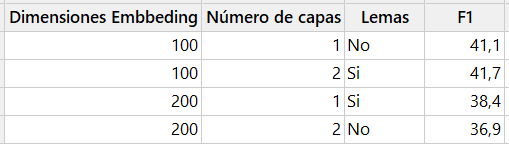

Realizados los 4 primeros experimentos se elaboró un gráfico de los valores obtenidos del F1 obtenido en función de cada factor analizado:

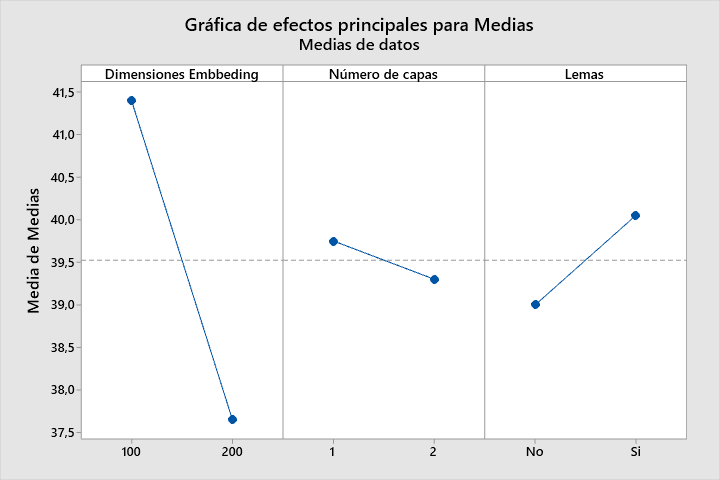

Observando las gráficas se puede inferir que los mejores valores para cada factor analizado son los siguientes:

In [ ]:
configs_final = Configs()
configs_final.embbeding_dims = [100,50]
configs_final.use_word2vec = False
configs_final.max_len = 250

Con estos resultados y parámetros se procedió a realizar el quinto experimento pero incluyendo una capa LSTM:

In [ ]:
configs_final.use_lstm = True

Este entrenamiento se realizó en Colab, para poder entrenar paralelamente aquí (Jupyter) el último experimento con Roberta (sexto experimento), se muestran los resultados obtenidos:

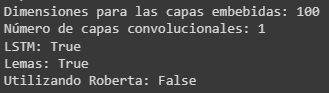

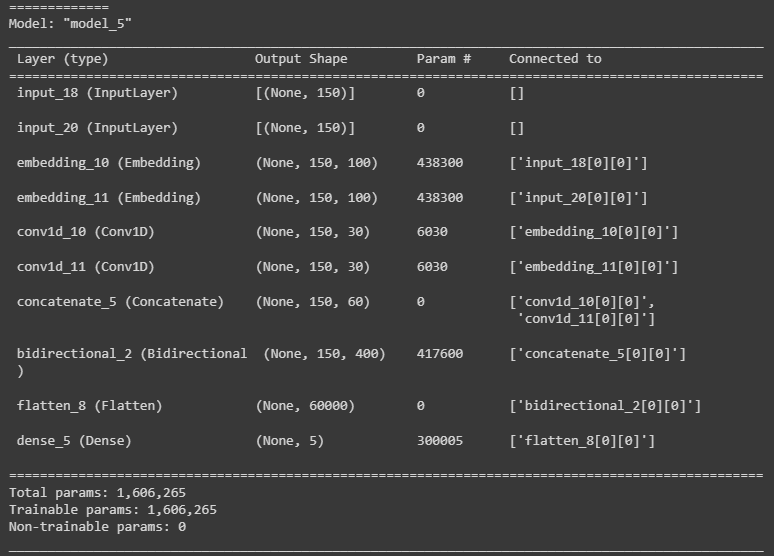

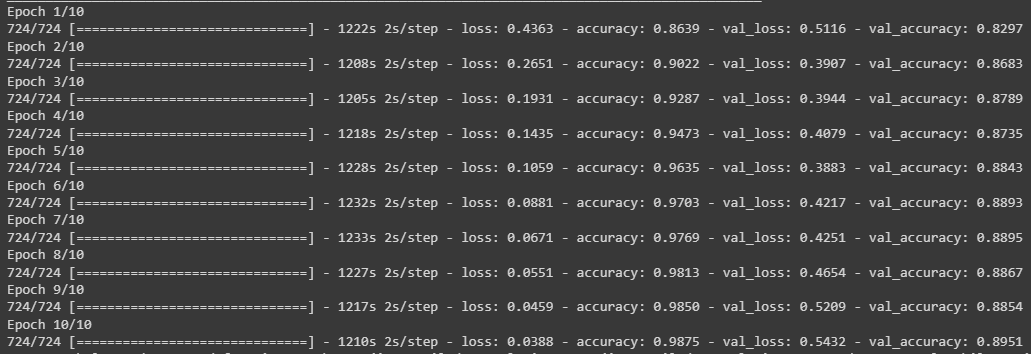

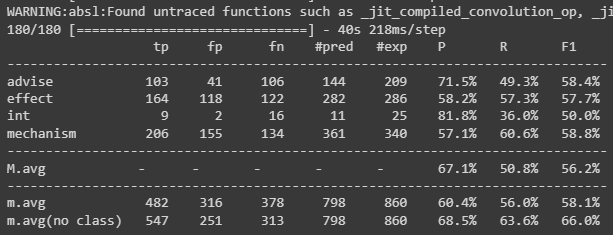

Por último se realizó el sexto experimento utilizando Roberta. No se utilizaron Lemas para acelerar el entrenamiento:

In [21]:
configs_final = Configs()

configs_final.embbeding_dims = 100
configs_final.num_capas_conv = 1
configs_final.use_lemmas = False
configs_final.use_roberta = True

In [ ]:
max_len = 150
suf_len = 5

print("Experimento Final con Roberta:")
print(configs_final)

codes = Codemaps(traindata, configs_final, max_len)

# build network
model = build_network(codes, configs_final)
model.summary()

# encode datasets
Xt = codes.encode_words(traindata)
Yt = codes.encode_labels(traindata)
Xv = codes.encode_words(valdata)
Yv = codes.encode_labels(valdata)

model.fit(Xt, Yt, batch_size=16, epochs=5, validation_data=(Xv,Yv), verbose=1)

# save model and indexs
model.save(modelname + str(exp))
codes.save(modelname + str(exp))

X = codes.encode_words(testdata)

Y = model.predict(X)
Y = [codes.idx2label(np.argmax(s)) for s in Y]

# extract relations
output_interactions(testdata, Y, outfile)
evaluator.evaluate("DDI",test_folder, outfile)

Experimento Final con Roberta:
Dimensiones para las capas embebidas: 100
Número de capas convolucionales: 1
LSTM: False
Lemas: False
Utilizando Roberta: True
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 150)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 150, 100)     438300      ['input_5[0][0]']                
                                                                                                  
 conv1d_2 (Conv1D)              (None, 150, 30)      6030        ['embedding_2[0][0]']            
                                                                                                  
 input_7 (InputLayer)           [

Debido al tiempo de entrenamiento con Roberta, no se alcanzó a entrenar por completo el último experimento; sin embargo, las primeras 3 épocas parecen tener un comportamiento similar a la arquitectura utilizando LSTM.

# 2. Arquitectura final

Debido a que no se terminó de entrenar el modelo utilizando Roberta, la arquitectura final corresponde a la combinación entre una CNN y LSTM:

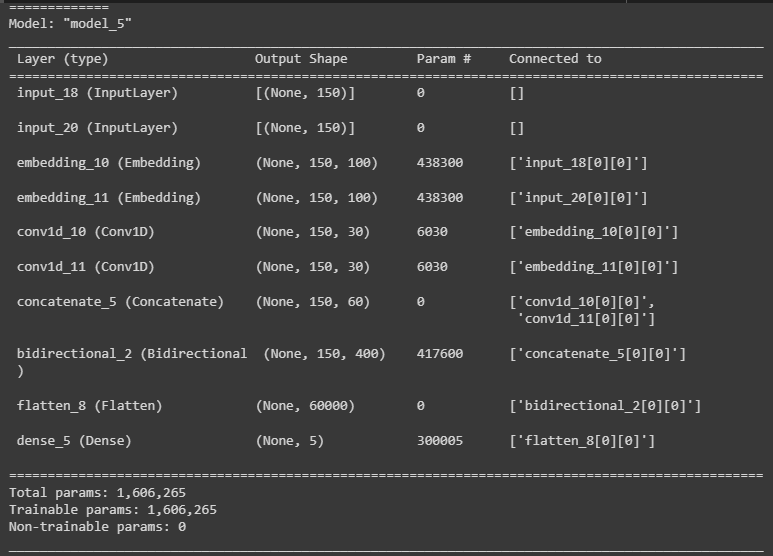

# 3. Información de Entrada

Se utilizó palabras y lemas. En el caso de Roberta se agregó la entrada de su tokenización.

# 4. Código

Los cambios solo fueron realizados en la clase Codemaps y en la función build_network. Se automatizó todo el proceso experimental utilizando una clase de configuración (al inicio de este Notebook).

# 5. Conclusiones

Se realizó un diseño experimental con los siguientes factores: dimensiones de la capa Embbeding, número de capas convolucionales y el uso de lemas, obteniéndose los mejores parámetros para dichos factores que consiguieron maximizar el F1-Score.

Con los mejores parámetros obtenidos del diseño experimental se entrenó otra red utiizando una capa adicional BiLSTM. Con ello se mejoró considerablemente el F1-Score llegando a un valor de 56.2%. 

Se cargo el modelo preentrenado de Roberta y se añadió a la red, misma que se entrenó parcialmente debido al tiempo necesario. Sin embargo, en las primeras épocas el comportamiento fue similar a la red entrenada con LSTM. Seria interesante unir esta última junto con Roberta y añadir más entradas para mejorar aún más el F1-Score.